To test if a general purpose sentiment analysis model can be used to predict the sentiment of political tweets.

In [20]:
# Define Model
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
from transformers import RobertaModel
from transformers import RobertaTokenizer
from roberta_classifer import RobertaClassifier
    
# Instantiate the model
model = RobertaClassifier()

# Load pre-trained weights
model.load_state_dict(torch.load('model_weights.pt'))

model.to('cuda')
# Set the model to evaluation mode
model.eval()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [2]:
import os

folder_path = 'data'

file_list = os.listdir(folder_path)

datasets = []

for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        print(f'Loading : {file_name}')
        datasets.append(pd.read_csv(file_path))

#Combine the datasets
dataset = pd.concat(datasets, ignore_index=True)
#Shuffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)

#Remove the unnecessary columns
dataset = dataset.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
dataset.dropna(subset=['text'], inplace=True)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.2, random_state=42)
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)



Loading : against-posts.csv
Loading : against1-posts.csv
Loading : pro-posts.csv
Loading : pro1-posts.csv


# Train

In [3]:
train_inputs, train_masks = model.preprocess_for_roberta(x_train)
print('Done training masking.')
test_inputs, test_masks = model.preprocess_for_roberta(x_test)
print('Done testing masking.')


100%|██████████| 5161/5161 [00:05<00:00, 980.60it/s] 


Done training masking.


100%|██████████| 1291/1291 [00:01<00:00, 713.60it/s]


Done testing masking.


In [4]:
# Batch Size
batch_size = 12

# Turn labels into a Tensor
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Create the DataLoader for our training set
train_dataloader = model.create_train_dataloader(train_inputs, train_masks, y_train, batch_size)

# Create the DataLoader for our testing set
test_dataloader = model.create_test_dataloader(test_inputs, test_masks, y_test, batch_size)




## Start Training Loop

In [5]:
import time
import random
import gc
import numpy as np
# Loss
loss_fn = nn.CrossEntropyLoss()

random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed_all(20)

def train(roberta_classifier, optimizer, scheduler, epochs=4):
    loss_hist = []
    model.train()
    for epoch in tqdm(range(epochs)):
        
        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        roberta_classifier.train()

        progress_bar = tqdm(total=len(train_dataloader), desc=f'Epoch {epoch+1}', position=0)
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            # Load batch to GPU
            batch_inputs, batch_masks, batch_labels = tuple(t.to('cuda') for t in batch)

            # Zero out gradients
            roberta_classifier.zero_grad()

            # Perform a forward pass.
            logits = roberta_classifier(batch_inputs, batch_masks)

            # Compute loss
            loss = loss_fn(logits, batch_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            
            # Perform a backward pass
            loss.backward()

            
            # Clip norm
            torch.nn.utils.clip_grad_norm_(roberta_classifier.parameters(), 1.0)

            # step optimizer, update params
            optimizer.step()
            scheduler.step()

            # Progress update every 20 batches.
            # if step % 20 == 0 and not step == 0:
            #     # Calculate elapsed time in minutes.
            #     elapsed = time.time() - t0_batch

            #     # Print training results
            #     print(f"{epoch:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {elapsed:^9.2f}")

            #     # Reset batch tracking variables
            #     batch_loss, batch_counts = 0, 0
            #     t0_batch = time.time()
            progress_bar.update(1)
            progress_bar.set_postfix({'Elapsed': time.time() - t0_epoch, 'Loss': total_loss / batch_counts})
        
        # Calculate the average loss
        avg_train_loss = total_loss / len(train_dataloader)
        loss_hist.append(avg_train_loss)
        print("-"*100)



In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

num_epochs = 4


optimizer = model.get_optimizer(lr=5e-5)
train(model, optimizer, model.get_scheduler(optimizer, train_dataloader, epochs=num_epochs), epochs=num_epochs)

 25%|██▌       | 1/4 [02:55<08:47, 175.75s/it],  2.90it/s, Elapsed=176, Loss=0.282] 

----------------------------------------------------------------------------------------------------


 50%|█████     | 2/4 [05:51<05:51, 175.85s/it],  3.14it/s, Elapsed=176, Loss=0.136] 

----------------------------------------------------------------------------------------------------


 75%|███████▌  | 3/4 [08:46<02:55, 175.60s/it],  3.12it/s, Elapsed=175, Loss=0.0512] 

----------------------------------------------------------------------------------------------------


Epoch 4: 100%|██████████| 431/431 [02:56<00:00,  2.44it/s, Elapsed=177, Loss=0.0218]

----------------------------------------------------------------------------------------------------


In [7]:
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    figure = plt.figure()
    plt.title(f'Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.annotate(f'Acc: {accuracy*100:.2f}%', xy=(0.8, 0.2))
    plt.show()
    return figure

In [8]:
import torch.nn.functional as F

def roberta_predict(test_dataloader):
    """Perform a forward pass on the trained Roberta model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.

    all_logits = []
    model.eval()
    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to('cuda') for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate confidence
    probs = F.softmax(all_logits, dim=1).cpu()

    return probs


AUC: 0.9936
Accuracy: 95.74%


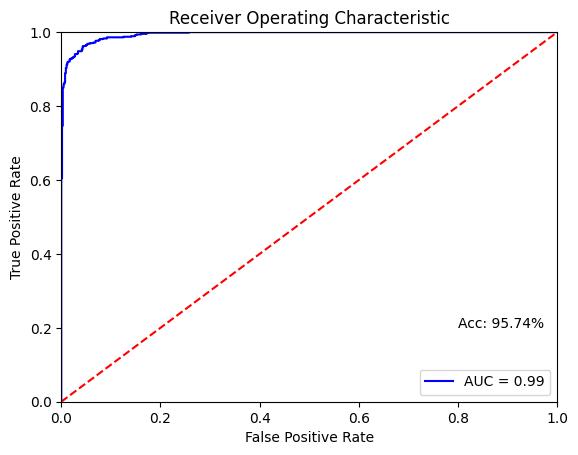

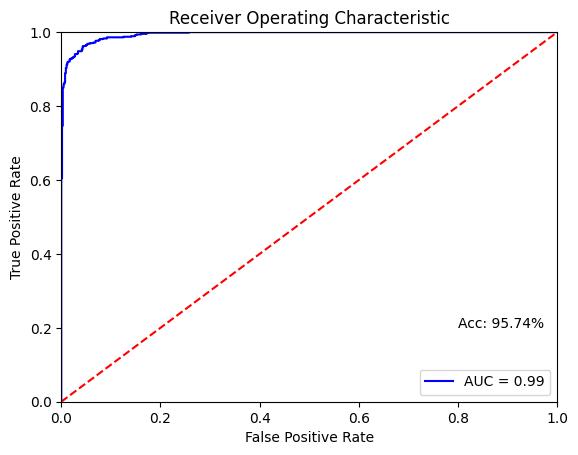

In [9]:
evaluate_roc(roberta_predict(test_dataloader), y_test)

In [10]:
# Save weights
torch.save(model.state_dict(), 'model_weights.pt')

In [11]:
def predict_prompt(prompt):

    model.eval()
    prompt = [prompt]
    prompt_inputs, prompt_masks = model.preprocess_for_roberta(prompt)
    prompt_inputs = torch.tensor(prompt_inputs)
    prompt_masks = torch.tensor(prompt_masks)
    prompt_dataloader = model.create_test_dataloader(prompt_inputs, prompt_masks, None, 1)
    probs = roberta_predict(prompt_dataloader)
    print(probs)
    return probs

In [23]:
prompt = "gun violence is a serious problem in the United States. We need to take action to stop it"
print(predict_prompt(prompt))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 499.02it/s]
C:\Users\Sam\AppData\Local\Temp\ipykernel_21416\2383580321.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_inputs = torch.tensor(prompt_inputs)
C:\Users\Sam\AppData\Local\Temp\ipykernel_21416\2383580321.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prompt_masks = torch.tensor(prompt_masks)


tensor([[6.9249e-04, 9.9931e-01]])
tensor([[6.9249e-04, 9.9931e-01]])


# Predicting on a Larger Set

In [27]:
comments = pd.read_csv('comment/comments.csv')
batch_size = 16
test_inputs, test_masks = model.preprocess_for_roberta(comments['comment_text'])

# Create dataloader
test_dataloader = model.create_test_dataloader(test_inputs, test_masks, labels=None, batch_size=batch_size)

# Compute predicted probabilities on the test set
probs = torch.argmax(roberta_predict(test_dataloader), dim=1)



100%|██████████| 660/660 [00:00<00:00, 1007.89it/s]


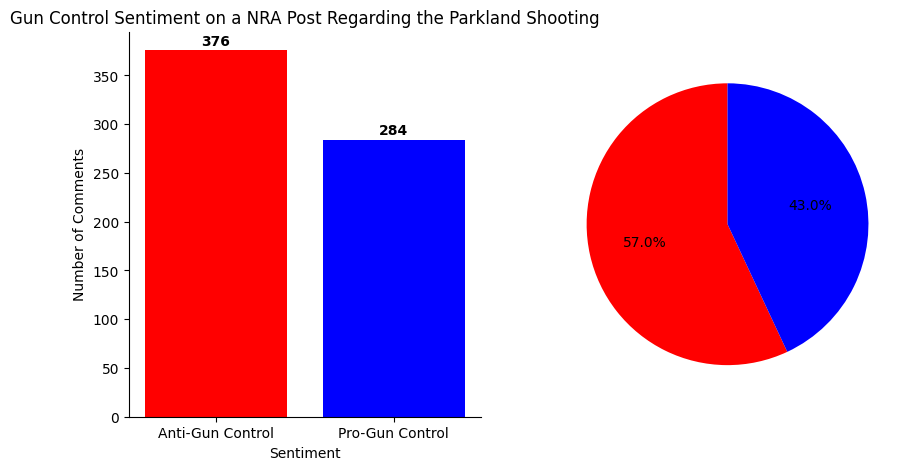

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

values = [torch.sum(probs == 0), torch.sum(probs == 1)]
ax1.bar(["Anti-Gun Control", "Pro-Gun Control"], values, color=["red", "blue"])
ax1.set_title("Gun Control Sentiment on a NRA Post Regarding the Parkland Shooting")
ax1.set_ylabel("Number of Comments")
ax1.set_xlabel("Sentiment")
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
for i, v in enumerate(values):
    ax1.text(i, v + 2, int(v), ha='center', va='bottom', fontweight='bold')

values = [torch.sum(probs == 0), torch.sum(probs == 1)]

colors = ["red", "blue"]

# Create a pie chart

ax2.pie(values, colors=colors, autopct='%1.1f%%', startangle=90)

# Display the pie chart
plt.show()




In [56]:
import gc
torch.cuda.empty_cache()
gc.collect()

61275